# Importation des librairies

In [1]:
from __future__ import annotations
import torch.nn.functional as F
import matplotlib.pyplot as plt
from munkres import Munkres
from typing import Optional
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random
import torch
import time
import math

## Implémentation de l'algorithme MCTS et des fonctions utilitaires

In [2]:
def get_mcts_cost(matrix: np.ndarray, config:dict, max_depth: int, max_iterations: int) -> tuple[list[int], float]:
    """Return the best actions and the cost of the best actions using MCTS."""
    state = np.stack([matrix, np.ones(matrix.shape), np.zeros(matrix.shape)], axis=0)
    actions = []
    for i in range(matrix.shape[0]):
        root = Node(state, config, depth=i)
        mcts = MCTS(root, config, max_depth, max_iterations)
        action = mcts.search()
        actions.append(action)
        state[1][i] = 0
        state[1][:, action] = 0
        state[2][i][action] = 1

    return actions, sum(matrix[i][action] for i, action in enumerate(actions))

def get_untried_actions(state: np.ndarray, depth: int) -> list[int]:
    """Return a list of untried actions."""
    if depth >= state[1].shape[0]:
        return []
    return np.argwhere(state[1][depth] == 1).flatten().tolist()


class Node:

    def __init__(self, state: np.ndarray, config: dict, parent=None, action=None, depth=0):
        self.state = state
        self.config = config
        self.parent = parent
        self.action = action
        self.depth = depth

        self.children: list[Node] = []

        self.visit_count = 0
        self.value = 0

    def is_expanded(self) -> bool:
        """Returns True if the node has children."""
        return len(self.children) > 0

    def select(self) -> Optional[Node]:
        """Return the child with the highest UCB score."""
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child: Node) -> float:
        """Return the UCB score of a child node."""
        if child.visit_count == 0:
            return np.inf
        exploitation = child.value / child.visit_count
        exploration = self.config["exploration_constant"] * np.sqrt(np.log(self.visit_count) / child.visit_count)

        return exploitation + exploration

    def expand(self) -> None:
        """Expand the node by creating all possible children."""
        child = None
        for action in get_untried_actions(self.state, self.depth):
            new_state = self.state.copy()
            new_state[1][self.depth] = 0
            new_state[1][:, action] = 0
            new_state[2][self.depth][action] = 1

            child = Node(new_state, self.config, self, action, self.depth + 1)
            self.children.append(child)

    def backpropagate(self, value: float) -> None:
        """Update the node's value and visit count."""
        self.value += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)


class MCTS:

    def __init__(self, root: Node, config: dict, max_depth: int, max_iterations: int = 1000):
        self.root = root
        self.config = config
        self.max_depth = max_depth
        self.max_iterations = max_iterations

    def search(self) -> int:
        for _ in range(self.max_iterations):
            node = self.select_node()
            value = self.rollout(node)
            node.backpropagate(value)

        best_action = None
        best_value = -np.inf
        for child in self.root.children:
            if child.visit_count > best_value:
                best_action = child.action
                best_value = child.visit_count
        if best_action is None:
            raise ValueError("No best action found.")
        return int(best_action)

    def select_node(self) -> Node:
        """Select a node to expand."""
        node = self.root
        while node.is_expanded():
            node = node.select()
            if node is None:
                raise ValueError("Selecting a childless node.")
        if not node.is_expanded():
            node.expand()
        return node

    def rollout(self, node: Node) -> float:
        """Simulate a game from the given node."""
        state = node.state.copy()
        depth = node.depth
        while depth < self.max_depth:
            actions = get_untried_actions(state, depth)
            if len(actions) == 1:
                action = actions[0]
            elif self.config["rollout_mode"] == "random":
                action = random.choice(actions)
            else:
                actions_values = [state[0][depth][action] for action in actions]
                total_value = sum(actions_values)
                action_probs = [abs((value - total_value) ** 2) for value in actions_values]
                normalized_probs = [prob / sum(action_probs) for prob in action_probs]
                action = random.choices(actions, normalized_probs)[0]

            state[1][depth] = 0
            state[1][:, action] = 0
            state[2][depth][action] = 1
            depth += 1
        return self.evaluate(state)

    def evaluate(self, state: np.ndarray) -> float:
        """Evaluate the given state."""
        return 1 - np.multiply(state[0], state[2]).sum() / state[0].sum()

## Test de l'algorithme MCTS sur le problème du LSAP

In [18]:
mcts_config = {
    "exploration_constant": 2,
    "rollout_mode": "random"
}

# Création d'une matrice aléatoire
matrix_size = 10
matrix = np.random.randint(1, 20, (matrix_size, matrix_size))

# Algorithme MCTS
actions, cost = get_mcts_cost(matrix, mcts_config, matrix_size, 1000)
print(f"Random matrix:\n{matrix}")
print(f"Nombre de possibilitées pour une matrice de taille {matrix_size}x{matrix_size} : {math.factorial(matrix_size):_}")
print(f"MCST actions: {actions}")
print(f"MCTS cost: {cost}")

# Algorithme hongrois
m = Munkres()
indexes = m.compute(matrix.copy().tolist())
cost = 0
for row, column in indexes:
    value = matrix[row][column]
    cost += value
print(f"Hungarian actions: {[column for row, column in indexes]}")
print(f"Hungarian cost: {cost}")

Random matrix:
[[ 6 11  3 14 14  9 13 12 12  3]
 [ 5  7 17  6  7  7 10 13 15 14]
 [13 18 10  8  3 15 15 14  4  4]
 [ 1  1  9  2  2  5 15  6  9 19]
 [ 3 11 18 11 15  9  9  5 19  7]
 [16 15 14  9  6  3  2  1 11 19]
 [ 7  4  2 19  3  9  6  3  1  1]
 [ 8  8 17 14  7 14  8 15 18 11]
 [10 16  3 13  8 15  8 15 17 16]
 [14  8  9  6  9  3 13  2 19  4]]
Nombre de possibilitées pour une matrice de taille 10x10 : 3_628_800
MCST actions: [2, 1, 8, 3, 0, 7, 9, 6, 4, 5]
MCTS cost: 40
Hungarian actions: [9, 3, 4, 1, 0, 7, 8, 6, 2, 5]
Hungarian cost: 32


## Benchmark de l'algorithme MCTS sur le problème du LSAP contre l'algorithme hongrois

In [20]:
mcts_config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

simulation_number = 100
mcts_simulation_number = 1000
matrix_size = 10

mcts_costs = []
hungarian_costs = []
mcts_times = []
hungarian_times = []


for _ in tqdm(range(simulation_number)):
    matrix = np.random.randint(1, 20, (matrix_size, matrix_size))

    start = time.time()
    actions, cost = get_mcts_cost(matrix, mcts_config, matrix_size, mcts_simulation_number)
    mcts_times.append(time.time() - start)
    mcts_costs.append(cost)

    start = time.time()
    indexes = m.compute(matrix.copy().tolist())
    cost = 0
    for row, column in indexes:
        value = matrix[row][column]
        cost += value
    hungarian_times.append(time.time() - start)
    hungarian_costs.append(cost)

print(f"Nombre de possibilitées pour une matrice de taille {matrix_size}x{matrix_size} : {math.factorial(matrix_size):_}")

print(f"MCTS cost: {np.mean(mcts_costs):.3f}, time: {np.mean(mcts_times):.5f}s")
print(f"Hungarian cost: {np.mean(hungarian_costs):.3f}, time: {np.mean(hungarian_times):.5f}s")

100%|██████████| 100/100 [01:50<00:00,  1.11s/it]

Nombre de possibilitées pour une matrice de taille 10x10 : 3_628_800
MCTS cost: 35.600, time: 1.10760s
Hungarian cost: 31.520, time: 0.00048s


## Impacts des paramètres de l'algorithme MCTS sur la qualité de la solution

### Paramètre de la constante d'exploration

100%|██████████| 10/10 [01:54<00:00, 11.49s/it]


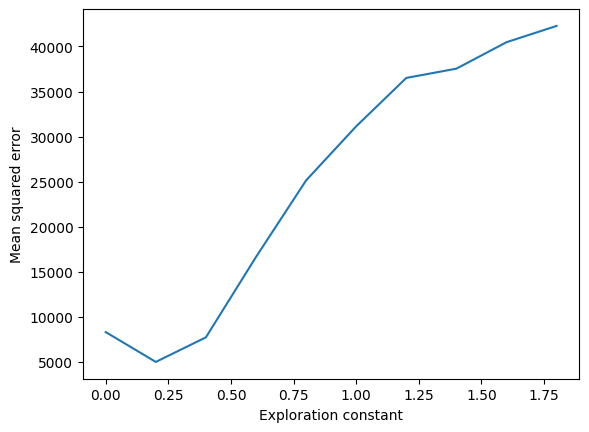

In [21]:
simulation_number = 100
mcts_simulation_number = 100
matrix_size = 10

errors = []
for c in tqdm(np.arange(0, 2, 0.2)):
    config = {
        "exploration_constant": c,
        "rollout_mode": "other"
    }
    mstc_scores = []
    munkres_scores = []
    for _ in range(simulation_number):
        random_matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
        _, mcts_cost = get_mcts_cost(random_matrix, config, matrix_size, mcts_simulation_number)
        mstc_scores.append(mcts_cost)

        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        cost = 0
        for row, column in indexes:
            value = random_matrix[row][column]
            cost += value
        munkres_scores.append(cost)

    errors.append(np.mean((np.array(mstc_scores) - np.array(munkres_scores)) ** 2))

plt.plot(np.arange(0, 2, 0.2), errors)
plt.xlabel("Exploration constant")
plt.ylabel("Mean squared error")
plt.show()

### Paramètre du nombre de simulations

100%|██████████| 5/5 [04:43<00:00, 56.76s/it]


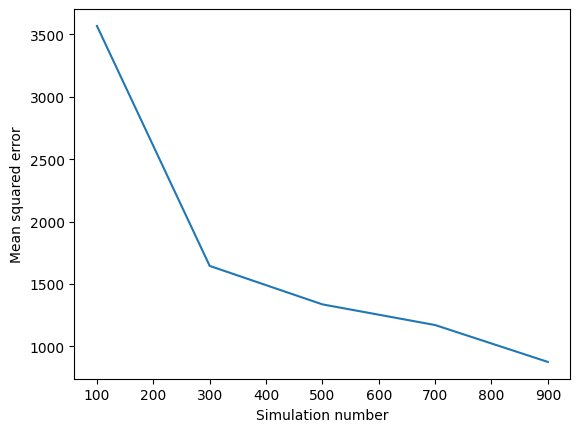

In [22]:
simulation_number = 100
mcts_simulation_number = 100
matrix_size = 10

config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

errors = []
for exploration_number in tqdm(range(100, 1000, 200)):

    mstc_scores = []
    munkres_scores = []
    for _ in range(simulation_number):
        random_matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
        _, mcts_cost = get_mcts_cost(
            random_matrix, config, matrix_size, exploration_number
        )
        mstc_scores.append(mcts_cost)

        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        cost = 0
        for row, column in indexes:
            value = random_matrix[row][column]
            cost += value
        munkres_scores.append(cost)

    errors.append(
        np.mean((np.array(mstc_scores) - np.array(munkres_scores)) ** 2))

plt.plot(range(100, 1000, 200), errors)
plt.xlabel("Simulation number")
plt.ylabel("Mean squared error")
plt.show()

## Création du modèle de prédiction

In [23]:
class CNNModel(nn.Module):

    def __init__(self, state_size: int, input_size: int, num_hidden: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, num_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.fc = nn.Linear(num_hidden * state_size, 2)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through thenetwork."""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Fonction de création des données d'entraînement

In [51]:
def process_matrix(matrix: np.ndarray, size: int) -> np.ndarray:
    """Process the matrix to be used as input for the model."""
    matrix = matrix.astype(np.float32)
    for i in range(size):
        total_value = matrix[i].sum()
        probs = [abs((value - total_value) ** 2) for value in matrix[i]]
        normalized_probs = [prob / sum(probs) for prob in probs]
        matrix[i] = np.round(normalized_probs, 2)
    return matrix


def generate_datas(n: int, size: int) -> tuple[np.ndarray, np.ndarray]:
    states = []
    values = []

    for _ in range(n):
        # Create a random matrix and a random permutation
        random_matrix = np.random.randint(1, 100, (size, size)).astype(np.float32)
        # Normalize the matrix line by line
        random_matrix = process_matrix(random_matrix, size)

        # Solve the problem with the Hungarian algorithm
        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        valide_solution = np.zeros((size, size))
        for row, column in indexes:
            valide_solution[row][column] = 1


        state = np.stack([random_matrix, valide_solution], axis=0)
        state = torch.tensor(state, dtype=torch.float32)
        states.append(state)
        values.append(1)

        # Create a random solution
        random_permutation = np.random.permutation(size)
        solution = np.zeros((size, size))
        is_valid = True
        for k in range(np.random.randint(1, size + 1)):
            solution[k][random_permutation[k]] = 1
            if valide_solution[k][random_permutation[k]] != 1:
                is_valid = False

        state = np.stack([random_matrix, solution], axis=0)
        states.append(state)
        values.append(1 if is_valid else 0)

    return np.stack(states, axis=0), np.array(values)


def generate_datas_2(n: int, size: int) -> tuple[np.ndarray, np.ndarray]:
    states = []
    values = []

    for _ in range(n):
        # Create a random matrix and a random permutation
        random_matrix = np.random.randint(1, 100, (size, size)).astype(np.float32)
        # Normalize the matrix line by line
        random_matrix = process_matrix(random_matrix, size)

        # Solve the problem with the Hungarian algorithm
        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        valide_solution = np.zeros((size, size))
        for row, column in indexes:
            valide_solution[row][column] = 1

        valid_solution_sum = round(np.multiply(random_matrix, valide_solution).sum(), 2)

        valid_state = np.stack([random_matrix, valide_solution], axis=0)
        valid_state = torch.tensor(valid_state, dtype=torch.float32)
        states.append(valid_state)
        values.append(1)

        # remove a random number of values from the solution
        partial_solution = valide_solution.copy()
        for k in range(np.random.randint(size)):
            line = size - k - 1
            indexes = np.argwhere(partial_solution[line] == 1).flatten()
            if len(indexes) > 0:
                partial_solution[line][indexes[0]] = 0
        
        partial_state = np.stack([random_matrix, partial_solution], axis=0)
        states.append(torch.tensor(partial_state, dtype=torch.float32))
        values.append(1)

        # Create a random solution
        random_permutation = np.random.permutation(size)
        solution = np.zeros((size, size))
        for k in range(size):
            solution[k][random_permutation[k]] = 1

        solution_sum = round(np.multiply(random_matrix, solution).sum(), 2)
        
        state = np.stack([random_matrix, solution], axis=0)
        states.append(torch.tensor(state, dtype=torch.float32))
        if solution_sum == valid_solution_sum:
            values.append(1)
        else:
            values.append(0)

        # remove a random number of values from the solution
        partial_solution = solution.copy()
        for k in range(np.random.randint(size)):
            line = size - k - 1
            indexes = np.argwhere(partial_solution[line] == 1).flatten()
            if len(indexes) > 0:
                partial_solution[line][indexes[0]] = 0

        partial_state = np.stack([random_matrix, partial_solution], axis=0)
        states.append(torch.tensor(partial_state, dtype=torch.float32))
        if solution_sum == valid_solution_sum:
            values.append(1)
        else:
            values.append(0)

    return np.stack(states, axis=0), np.array(values)


size = 5
random_matrix = np.random.randint(1, 100, (size, size)).astype(np.float32)
print(f"Random matrix:\n{random_matrix}")
print(f"Processed matrix:\n{process_matrix(random_matrix, size)}")

Random matrix:
[[22. 87. 89. 71. 55.]
 [81. 90. 34. 82. 54.]
 [39. 91. 22. 36. 24.]
 [ 8. 51. 61. 27.  2.]
 [93.  9. 44. 39. 17.]]
Processed matrix:
[[0.27 0.17 0.16 0.19 0.21]
 [0.18 0.17 0.25 0.18 0.22]
 [0.2  0.1  0.25 0.21 0.24]
 [0.27 0.13 0.11 0.2  0.29]
 [0.09 0.28 0.19 0.2  0.25]]


### Entrainement du modèle

In [53]:
size = 10

model = CNNModel(
    state_size=size**2,
    input_size=2,
    num_hidden=64
)

train_states, train_values = generate_datas_2(10000, size)

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)

        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}")

# Test the model
size = 10
test_states, test_values = generate_datas(100, size)
outputs = model(torch.tensor(test_states, dtype=torch.float32))
values = test_values
values = values.reshape(-1, 1)
values = np.concatenate([1 - values, values], axis=1)
loss = criterion(outputs, torch.tensor(values, dtype=torch.float32))
print(f"Test loss: {loss.item() * 10:.2f}")

Epoch 1, loss: 2.51
Epoch 2, loss: 1.91
Epoch 3, loss: 0.56
Epoch 4, loss: 0.42
Epoch 5, loss: 0.37
Epoch 6, loss: 0.34
Epoch 7, loss: 0.32
Epoch 8, loss: 0.31
Epoch 9, loss: 0.30
Epoch 10, loss: 0.29
Test loss: 0.38


### Test du modèle

In [55]:
test_states, test_values = generate_datas_2(1, size)
print(test_states, test_values)
outputs = model(torch.tensor(test_states, dtype=torch.float32))
print(outputs)

[[[[0.09 0.11 0.11 0.11 0.1  0.11 0.1  0.12 0.08 0.07]
   [0.09 0.1  0.09 0.12 0.1  0.1  0.11 0.09 0.1  0.09]
   [0.09 0.08 0.1  0.09 0.1  0.07 0.12 0.11 0.12 0.11]
   [0.08 0.08 0.1  0.12 0.11 0.09 0.11 0.1  0.12 0.09]
   [0.11 0.08 0.07 0.1  0.08 0.12 0.12 0.11 0.1  0.11]
   [0.12 0.09 0.1  0.11 0.1  0.12 0.08 0.1  0.1  0.08]
   [0.11 0.12 0.09 0.11 0.08 0.11 0.09 0.09 0.09 0.11]
   [0.08 0.09 0.09 0.12 0.09 0.11 0.11 0.11 0.09 0.11]
   [0.11 0.12 0.09 0.08 0.12 0.12 0.09 0.1  0.1  0.08]
   [0.1  0.1  0.12 0.11 0.09 0.1  0.1  0.09 0.11 0.09]]

  [[0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
   [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
   [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
   [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
   [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
   [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.  

## Modification de l'algorithme MCTS pour utiliser le modèle de prédiction

In [62]:
def get_untried_actions(state: np.ndarray, depth: int) -> list[int]:
    """Return a list of untried actions."""
    if depth >= state[1].shape[0]:
        return []
    return np.argwhere(state[1][depth] == 1).flatten().tolist()


class Node:

    def __init__(self, state: np.ndarray, config: dict, parent=None, action=None, depth=0):
        self.state = state
        self.config = config
        self.parent = parent
        self.action = action
        self.depth = depth

        self.children: list[Node] = []

        self.visit_count = 0
        self.value = 0

    def is_expanded(self) -> bool:
        """Returns True if the node has children."""
        return len(self.children) > 0

    def select(self) -> Optional[Node]:
        """Return the child with the highest UCB score."""
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child: Node) -> float:
        """Return the UCB score of a child node."""
        if child.visit_count == 0:
            return np.inf
        exploitation = child.value / child.visit_count
        exploration = self.config["exploration_constant"] * \
            np.sqrt(np.log(self.visit_count) / child.visit_count)

        return exploitation + exploration

    def expand(self) -> None:
        """Expand the node by creating all possible children."""
        child = None
        for action in get_untried_actions(self.state, self.depth):
            new_state = self.state.copy()
            new_state[1][self.depth] = 0
            new_state[1][:, action] = 0
            new_state[2][self.depth][action] = 1

            child = Node(new_state, self.config, self, action, self.depth + 1)
            self.children.append(child)

    def backpropagate(self, value: float) -> None:
        """Update the node's value and visit count."""
        self.value += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)


class MCTS:

    def __init__(
        self, root: Node, config: dict, max_depth: int,
        model: nn.Module, max_iterations: int = 1000
    ) -> None:
        self.root = root
        self.config = config
        self.max_depth = max_depth
        self.model = model
        self.max_iterations = max_iterations

    def search(self) -> int:
        for _ in range(self.max_iterations):
            node = self.select_node()
            value = self.rollout(node)
            node.backpropagate(value)

        best_action = None
        best_value = -np.inf
        for child in self.root.children:
            if child.visit_count > best_value:
                best_action = child.action
                best_value = child.visit_count
        if best_action is None:
            raise ValueError("No best action found.")
        return int(best_action)

    def select_node(self) -> Node:
        """Select a node to expand."""
        node = self.root
        while node.is_expanded():
            node = node.select()
            if node is None:
                raise ValueError("Selecting a childless node.")
        if not node.is_expanded():
            node.expand()
        return node

    def rollout(self, node: Node) -> float:
        """Simulate a game from the given node."""
        state = node.state.copy()
        model_matrix = process_matrix(state[0], state[0].shape[0])
        
        model_state = np.stack([model_matrix, state[2]], axis=0)
        model_state = torch.tensor(model_state, dtype=torch.float32).unsqueeze(0)
        return self.model(model_state).argmax().item()


def get_mcts_cost(matrix: np.ndarray, config: dict, max_depth: int, max_iterations: int, model: nn.Module) -> tuple[list[int], float]:
    """Return the best actions and the cost of the best actions using MCTS."""
    state = np.stack([matrix, np.ones(matrix.shape),
                     np.zeros(matrix.shape)], axis=0)
    actions = []
    for i in range(matrix.shape[0]):
        root = Node(state, config, depth=i)
        mcts = MCTS(root, config, max_depth, model, max_iterations)
        action = mcts.search()
        actions.append(action)
        state[1][i] = 0
        state[1][:, action] = 0
        state[2][i][action] = 1

    return actions, sum(matrix[i][action] for i, action in enumerate(actions))


In [9]:
size = 5

model = CNNModel(
    state_size=size**2,
    input_size=2,
    num_hidden=64
)

train_states, train_values = generate_datas(10000, size)

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(30):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)

        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}")

Epoch 1, loss: 1.13
Epoch 2, loss: 0.54
Epoch 3, loss: 0.39
Epoch 4, loss: 0.36
Epoch 5, loss: 0.32
Epoch 6, loss: 0.29
Epoch 7, loss: 0.28
Epoch 8, loss: 0.28
Epoch 9, loss: 0.25
Epoch 10, loss: 0.24
Epoch 11, loss: 0.23
Epoch 12, loss: 0.21
Epoch 13, loss: 0.20
Epoch 14, loss: 0.18
Epoch 15, loss: 0.18
Epoch 16, loss: 0.16
Epoch 17, loss: 0.15
Epoch 18, loss: 0.14
Epoch 19, loss: 0.14
Epoch 20, loss: 0.13
Epoch 21, loss: 0.11
Epoch 22, loss: 0.10
Epoch 23, loss: 0.10
Epoch 24, loss: 0.09
Epoch 25, loss: 0.09
Epoch 26, loss: 0.08
Epoch 27, loss: 0.07
Epoch 28, loss: 0.08
Epoch 29, loss: 0.06
Epoch 30, loss: 0.06


In [58]:
test_states, test_values = generate_datas_2(1, size)
test_states = np.array([test_states[random.randint(0, 1)]])
test_values = np.array([test_values[random.randint(0, 1)]])


print(torch.tensor(test_states, dtype=torch.float32), test_values)
outputs = model(torch.tensor(test_states, dtype=torch.float32))
print(outputs)

tensor([[[[0.1100, 0.0900, 0.1100, 0.1100, 0.0900, 0.1100, 0.0900, 0.0900,
           0.1200, 0.0900],
          [0.0900, 0.1000, 0.1200, 0.1100, 0.0900, 0.1200, 0.0800, 0.1100,
           0.0900, 0.0900],
          [0.1000, 0.1000, 0.1100, 0.0900, 0.1100, 0.0900, 0.1100, 0.0900,
           0.1000, 0.1000],
          [0.0900, 0.1100, 0.1000, 0.1200, 0.0900, 0.0900, 0.0900, 0.1200,
           0.0900, 0.0900],
          [0.1100, 0.1000, 0.1000, 0.1100, 0.0700, 0.1100, 0.0800, 0.0900,
           0.1200, 0.1000],
          [0.1200, 0.1100, 0.1100, 0.1200, 0.1000, 0.1200, 0.0600, 0.1200,
           0.0700, 0.0800],
          [0.0900, 0.1200, 0.1000, 0.1100, 0.1200, 0.1100, 0.0900, 0.0900,
           0.0900, 0.1000],
          [0.1000, 0.1100, 0.1100, 0.0900, 0.1000, 0.1000, 0.0900, 0.1000,
           0.1100, 0.0900],
          [0.0800, 0.0900, 0.0900, 0.1000, 0.1100, 0.1200, 0.1200, 0.0900,
           0.1200, 0.0800],
          [0.1100, 0.0900, 0.1200, 0.1100, 0.1100, 0.1100, 0.0900, 0.0800

In [65]:
matrix_size = 10

mcts_config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

mcts_simulation_number = 1000

random_matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
_, mcts_cost = get_mcts_cost(
    random_matrix, mcts_config, matrix_size, mcts_simulation_number, model
)

print(f"MCTS cost: {mcts_cost:.3f}")

# Algorithme hongrois
m = Munkres()
indexes = m.compute(random_matrix.copy().tolist())
cost = 0
for row, column in indexes:
    value = random_matrix[row][column]
    cost += value
print(f"Hungarian cost: {cost:.3f}")

MCTS cost: 727.000
Hungarian cost: 126.000


In [92]:
matrix_size = 10
matrix = np.random.randint(1, 100, (matrix_size, matrix_size))

root_state = np.stack([matrix, np.ones(matrix.shape), np.zeros(matrix.shape)], axis=0)
root_state[2][0][0] = 1
print(root_state)

model_matrix = process_matrix(root_state[0], root_state[0].shape[0])
        
model_state = np.stack([model_matrix, root_state[2].astype(np.int32)], axis=0)
model_state = torch.tensor(model_state, dtype=torch.float32).unsqueeze(0)
print(model_state)
model_value = model(model_state)
print(model_value)

# munkres
m = Munkres()
indexes = m.compute(matrix.copy().tolist())
cost_matrix = np.zeros(matrix.shape)
for row, column in indexes:
    cost_matrix[row][column] = 1
print(cost_matrix)

solution = np.zeros((matrix_size, matrix_size))
random_permutation = np.random.permutation(matrix_size)

is_valid = True
for k in range(np.random.randint(1, size + 1)):
    solution[k][random_permutation[k]] = 1
    if cost_matrix[k][random_permutation[k]] != 1:
        is_valid = False
print(is_valid)


[[[ 2. 70. 23. 75. 74. 10. 61. 74. 21. 64.]
  [40. 94. 83. 20. 62. 53. 90. 38. 46. 60.]
  [34. 21. 79.  7. 60. 82. 38. 73. 74. 49.]
  [56. 52. 35. 20. 29. 95. 64.  5. 29. 34.]
  [42. 92. 30. 30. 28. 80. 54. 30. 55.  8.]
  [88. 45. 10. 77. 36. 14. 29. 75. 36. 78.]
  [36. 13. 65. 99. 93. 88. 49. 31.  3. 41.]
  [59. 20.  4. 63. 25. 97. 73. 51.  3. 13.]
  [33.  5. 71. 18. 72. 63. 23. 24. 32. 31.]
  [25. 76. 64. 64. 64. 46. 21. 29. 26. 57.]]

 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]

 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  